In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.densenet import DenseNet121 
from tensorflow.keras.applications.efficientnet import *
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K 
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os, sys
import cv2
import random
%matplotlib inline

In [3]:
#ROOT_DIR = 
DATA_SETS = '../input/ranzcr-clip-catheter-line-classification'
#SCRIPTS = 

In [4]:
datasets_list = os.listdir(DATA_SETS)
datasets_list

['train_tfrecords',
 'sample_submission.csv',
 'train_annotations.csv',
 'test_tfrecords',
 'train.csv',
 'test',
 'train']

In [5]:
train = os.path.join(DATA_SETS, 'train')
submission = os.path.join(DATA_SETS,'sample_submission.csv')
test = os.path.join(DATA_SETS, 'test')

In [6]:
train_df = pd.read_csv(DATA_SETS+'/train.csv')
print(f'Train Data CSV: {train_df.shape[0]}')
train_df.head()

Train Data CSV: 30083


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


In [7]:
sub_df = pd.read_csv(submission)
print(f'Sub CSV: {sub_df.shape[0]}')
sub_df.head()

Sub CSV: 3582


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,0,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,0,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,0,0,0,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.8.498.84994474380235968109...,0,0,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.35798987793805669662...,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# label column names
label_cols = list(sub_df.columns[1:])
image_labels = train_df[label_cols].values # will be used for train validation splitting

In [9]:
# Count up the number of instances of each class (drop non-class columns from the counts) 
class_counts = train_df.sum().drop(['StudyInstanceUID','PatientID'])

In [10]:
# we plot the distribution of patients to check if there is any class imbalance in the dataset
def plot_class_distributions(values, index):
    sns.barplot(x=values, y=index)
    plt.title('Distribution of classes for the patients')
    plt.xlabel('Patient Count', fontsize=15)
    plt.ylabel('Catheter Position', fontsize=15)
    plt.show()

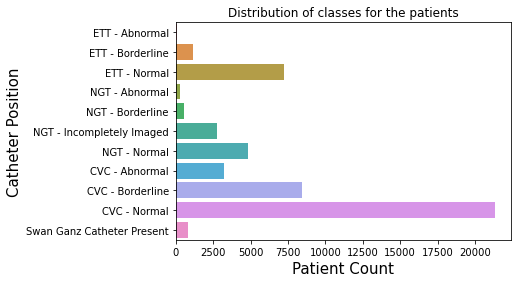

In [11]:
plot_class_distributions(class_counts.values, class_counts.index)

In [12]:
train_images = DATA_SETS + "/train/" + train_df['StudyInstanceUID'] + '.jpg'   
test_images = DATA_SETS + "/test/" + sub_df['StudyInstanceUID'] + '.jpg'
len(test_images)

3582

In [13]:
data_image = os.path.join(DATA_SETS, "train_annotations.csv")
data_image = pd.read_csv(data_image)
data_image.head()

,StudyInstanceUID,label,data
0,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1487, 1279], [1477, 1168], [1472, 1052], [14..."
1,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1328, 7], [1347, 101], [1383, 193], [1400, 2..."
2,1.2.826.0.1.3680043.8.498.72921907356394389969...,CVC - Borderline,"[[801, 1207], [812, 1112], [823, 1023], [842, ..."
3,1.2.826.0.1.3680043.8.498.11697104485452001927...,CVC - Normal,"[[1366, 961], [1411, 861], [1453, 751], [1508,..."
4,1.2.826.0.1.3680043.8.498.87704688663091069148...,NGT - Normal,"[[1862, 14], [1845, 293], [1801, 869], [1716, ..."


In [14]:
# display images randomly on a grid
def display_images(image_ids, labels):
    fig = plt.figure(figsize = (16,12))
    
    for index, (image_id, label) in enumerate(zip(image_ids,labels)):
        plt.subplot(3,3, index+1)
        image = image_id + '.jpg'
        image = mpimg.imread(os.path.join(DATA_SETS, "train", image))
        plt.title(label, fontsize=12)
        plt.imshow(image,cmap='Greys')
    
    fig.tight_layout()
    plt.show()    
        

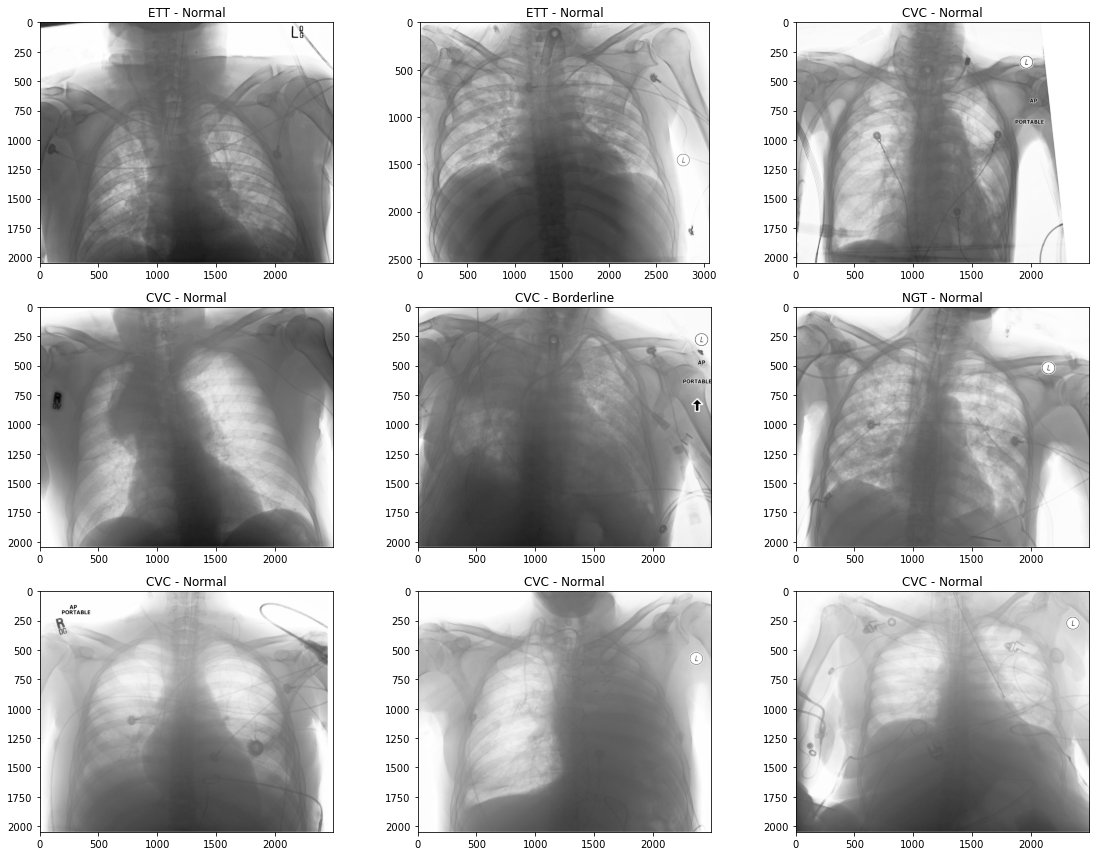

In [15]:
tmp_train = data_image.sample(9)
image_ids = tmp_train["StudyInstanceUID"].values
labels = tmp_train['label'].values
display_images(image_ids, labels)

In [16]:
# now we check for any kinds of data leakage between any two data sets, train-test, train-valid, valid-test
def check_for_leakage(df1, df2, patient_col):
    
    df1_unique = set(df1[patient_col])
    df2_unique = set(df2[patient_col])
    
    common_patients = df1_unique.intersection(df2_unique)
    
    return True if len(common_patients) > 0 else False
    
    

In [17]:
check_for_leakage(train_df, sub_df, 'StudyInstanceUID')

False

In [18]:
# for making validation set from given train set
def make_val_set(data, val_size):
    val_patientid = random.sample(list(train_df['PatientID'].unique()),int(val_size*len(train_df['PatientID'].unique())))
    df_train = data[~data['PatientID'].isin(val_patientid)]
    df_val = data[data['PatientID'].isin(val_patientid)]
    return df_train, df_val

In [19]:
df_train, df_val = make_val_set(train_df, val_size=0.2)

In [20]:
check_for_leakage(df_train, df_val, 'PatientID')

False

In [21]:
print(f'Train Data Size: {df_train.shape[0]}')
print(f'Validation Data Size: {df_val.shape[0]}')

Train Data Size: 24247
Validation Data Size: 5836


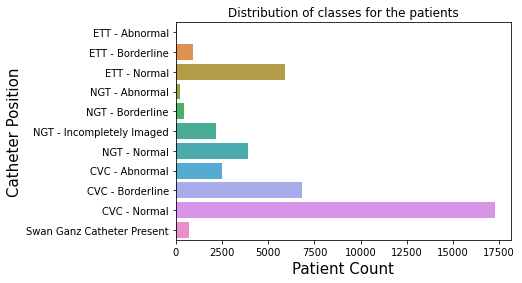

In [22]:
# class distribution in training set
train_class_counts = df_train.sum().drop(['StudyInstanceUID','PatientID'])

plot_class_distributions(train_class_counts.values, train_class_counts.index)

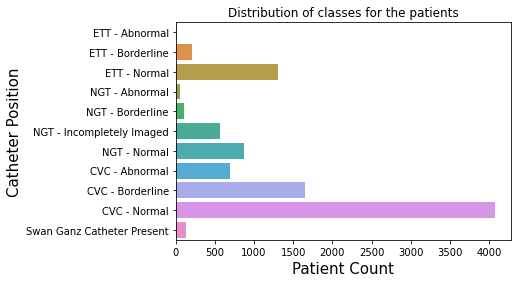

In [23]:
# class distribution in validation set

val_class_counts = df_val.sum().drop(['StudyInstanceUID','PatientID'])

plot_class_distributions(val_class_counts.values, val_class_counts.index)

In [24]:
TRAIN_IMAGE_DIR = DATA_SETS + '/train/'
TEST_IMAGE_DIR = DATA_SETS + '/test/'

In [25]:
# without augmentation
def get_train_generator(df, image_dir, image_id, label_names, shuffle=True, batch_size=16, seed=1, target_width=380, target_height=380):
    print('Train Generator Preparation: ')
    
    # first we normalize the images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization=True,
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip= True
    )

    
    # next we flow from data frame with a certain batch size.
    # This flows the images from the directory
    generator = image_generator.flow_from_dataframe(
        dataframe=df,
        directory=image_dir,
        x_col=image_id,
        y_col=label_names,
        class_mode="raw",
        classes=label_names,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=1,
        target_size=(target_width, target_height)
    )
    
    return generator
    

In [26]:
# create image generator
def get_image_generator(train_df, image_dir, image_id, label_names, shuffle=True, batch_size=16, seed=1, target_width=380, target_height=380, sample_size=100):
    # generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col=image_id,
        y_col=label_names,
        class_mode='raw',
        batch_size=sample_size,
        shuffle=shuffle,
        target_size=(target_width, target_height)
    )
    
    batch = raw_train_generator.next() 
    data_sample = batch[0] 
    
    # use sample to fit mean and std for test set generator 
    image_generator = ImageDataGenerator( 
        featurewise_center=True, 
        featurewise_std_normalization= True) 
    
    # fit generator to sample from training data 
    image_generator.fit(data_sample)
    
    return image_generator

In [27]:
def get_generator(df, image_dir, x_col, y_cols, image_generator, batch_size=32, seed=1, target_width = 380, target_height = 380):
    # get valid generator 
    generator = image_generator.flow_from_dataframe( 
        dataframe=df, 
        directory=image_dir, 
        x_col=x_col, y_col=y_cols, 
        class_mode="raw", 
        batch_size=batch_size, 
        shuffle=False, 
        seed=seed, 
        target_size=(target_width,target_height)
    )
    
    return generator

In [28]:
def append_ext(fn, ext='.jpg'):
    return fn+ext

df_train['StudyInstanceUID'] = df_train['StudyInstanceUID'].apply(append_ext)
df_val['StudyInstanceUID'] = df_val['StudyInstanceUID'].apply(append_ext)
sub_df['StudyInstanceUID'] = sub_df['StudyInstanceUID'].apply(append_ext)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [29]:
train_generator = get_train_generator(df_train, TRAIN_IMAGE_DIR, "StudyInstanceUID", label_cols)
raw_image_generator = get_image_generator(df_train, TRAIN_IMAGE_DIR, "StudyInstanceUID", label_cols)
valid_generator = get_generator(df_val, TRAIN_IMAGE_DIR, "StudyInstanceUID", label_cols, raw_image_generator)
test_generator= get_generator(sub_df, TEST_IMAGE_DIR, "StudyInstanceUID", label_cols, raw_image_generator)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:220: UserWarning: `classes` will be ignored given the class_mode="raw"
  .format(self.class_mode))


Train Generator Preparation: 
Found 24247 validated image filenames.
Found 24247 validated image filenames.
Found 5836 validated image filenames.
Found 3582 validated image filenames.


In [30]:
tf.keras.backend.clear_session()

efficient_net = EfficientNetB4(
    weights='imagenet',
    input_shape=(380,380,3),
    include_top=False,
    pooling='max'
)

efficient_net.summary()

71688192/71686520 [==============================] - 1s 0us/step
Model: "efficientnetb4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 380, 380, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 380, 380, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization[0][0]              
____________________

In [31]:
model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 512, activation='relu'))
model.add(Dense(units = 256, activation='relu'))
model.add(Dense(units = 11, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
dense (Dense)                (None, 512)               918016    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 11)                2827      
Total params: 18,725,994
Trainable params: 18,600,787
Non-trainable params: 125,207
_________________________________________________________________


In [32]:
!pip install focal-loss

from focal_loss import BinaryFocalLoss

In [33]:
# loss_fn = tf.keras.losses.BinaryCrossentropy(
#             from_logits=False,
#             label_smoothing=0,
#             reduction="auto",
#             name="binary_crossentropy",
#             )

loss_fn = BinaryFocalLoss(gamma=2)

model.compile(optimizer=Adam(lr=0.001), loss=loss_fn, metrics=['accuracy'])

In [34]:
early_cb = EarlyStopping(patience=10,
                         monitor='val_accuracy',
                         restore_best_weights=True
                        )

reduce_cb = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              min_lr=0.00001,
                              verbose=1
                             )

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
            filepath="./",
            save_weights_only=False,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True
        )

In [35]:
tf.keras.backend.clear_session()

history = model.fit(
    train_generator,
    epochs = 100,
    steps_per_epoch = 100,
    batch_size = 256,
    validation_data = valid_generator,
    validation_steps = 20,
    callbacks = [early_cb, reduce_cb]
)

Epoch 1/50
 19/100 [====>.........................] - ETA: 1:41 - loss: 0.9573 - accuracy: 0.2974

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'r',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'r',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')